In [2]:
import sys, os
sys.path.append('../code')
import numpy as np
import pandas as pd
import networkx as nx
import torch as th
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from itertools import chain
import matplotlib.pyplot as plt

from collections import Counter

from utils import *

vprint = lambda *x : print(*x) if verbose else None

Using backend: pytorch


In [3]:
lower_threshold = 100
upper_threshold = 10000
verbose = True

to_encode = ['user_followers_log',
            'user_followees_log',
            'user_account_age_log',
            'user_engagement_log',
            'retweet_delay_log',
            'user_verified']

to_display = ['user_followers',
            'user_followees',
            'user_account_age',
            'user_engagement',
            'retweet_delay']

to_group = ['user_followers',
    		'user_followees',
    		'user_account_age',
    		'user_engagement',
    		'retweet_delay']

pd.set_option('display.max_columns', 30)

In [4]:
def get_parents(df):
    df = df.copy()
    parents = df.groupby(['cascade_id','new_parent_tid']).agg({'tid':'count'}).reset_index().rename(columns={'tid':'n_children', 'new_parent_tid':'new_tid'})
    return parents

def crop(tweets, mode=False, threshold=False):

    cropped = tweets.copy()

    if threshold: 
    	if mode == 'time':
        	cropped = cropped[cropped.root_delay < threshold]
    	elif mode == 'number':
    		cropped = cropped[cropped.new_tid < threshold]

    cropped = pd.merge(cropped, get_parents(cropped), on = ['cascade_id','new_tid'], how = 'left').fillna({'n_children':0})
    cropped['is_leaf']  = (cropped.n_children == 0).astype(int)
    return cropped

def get_new_tid(df):
    df = df.copy()
    df['new_tid'] = df.groupby('cascade_id').cumcount().astype(int)
    parents = df[['cascade_id', 'tid', 'new_tid']].rename({'tid':'parent_tid', 'new_tid':'new_parent_tid'},axis=1)
    df = pd.merge(df, parents, on = ['cascade_id', 'parent_tid'], how = 'left')
    df.loc[df.new_parent_tid.isna(), 'new_parent_tid'] = -1
    return df['new_tid'], df['new_parent_tid']


def get_depths(df):

    print('getting_depths')
    
    all_depths = []
    
    for cid in tqdm(df.cascade_id.unique()):
        small = df[df.cascade_id == cid].copy()
        all_depths.append(get_nodes_depths(small))
    
    return list(chain(*all_depths))        
    
    

def get_nodes_depths(small):
    
    g = nx.DiGraph()
    g.add_nodes_from(small.new_tid.values)
    g.add_edges_from([(u, v) for u, v in zip(small.new_parent_tid, small.new_tid)][1:])

    depths = nx.shortest_path_length(g,0)
    
    return [depths[k] for k in sorted(depths.keys())]



def get_cascade_statistics(small):
    
    depths = small.depth
    cascade_depth = max(depths)
    cascade_breadth = max(Counter(depths).values())
    db_ratio = cascade_depth /cascade_breadth

    return cascade_depth, cascade_breadth, db_ratio

def to_grouped(df, to_group):
    
    aggs = {k:'mean' for k in to_group}
    aggs['n_children'] = 'max' 
        
    grouped = df.groupby(['cascade_id', 'cascade_size', 'cascade_followers']).agg(aggs).reset_index()

    sizes = []
    depths = []
    breadths = []
    db_ratios = []

    for cid in grouped.cascade_id:
        small = df[df.cascade_id == cid]
        depth, breadth, db_ratio = get_cascade_statistics(small)
        sizes.append(small.shape[0])
        depths.append(depth)
        breadths.append(breadth)
        db_ratios.append(db_ratio)

    grouped['size'], grouped['depth'], grouped['breadth'] = sizes, depths, breadths
    grouped['db_ratio'] = db_ratios

    return grouped

In [5]:
tweets = pd.read_csv('../data/tweets.csv')
print(tweets.shape)

(3703996, 26)


In [17]:
tweets.head()

,cascade_id,index,tid,veracity,rumor_id,rumor_category,parent_tid,tweet_date,user_account_age,user_verified,user_followers,user_followees,user_engagement,cascade_root_tid,was_retweeted,...,retweet_delay,hour_cos,hour_sin,wd_cos,wd_sin,root_datetime,root_delay,virality,cascade_size,cascade_followers,new_tid,new_parent_tid,depth,n_children,is_leaf
0,80150,159013,896850,False,r_465,Science/Nature/Tech/Food/Health,-1,2014-01-27 01:36:51,526.0,0,205122.0,141.0,1.6610,896850,1,...,0.0,0.9629,0.2698,1.0,0.0,2014-01-27 01:36:51,0.0,2.0584,100,732251.0,0,-1.0,0,95.0,0
1,80150,159035,896872,False,r_465,Science/Nature/Tech/Food/Health,896850,2014-01-27 01:37:11,682.0,0,64.0,231.0,2.7424,896850,0,...,20.0,0.9629,0.2698,1.0,0.0,2014-01-27 01:36:51,20.0,2.0584,100,732251.0,1,0.0,1,0.0,1
2,80150,159023,896860,False,r_465,Science/Nature/Tech/Food/Health,896850,2014-01-27 01:37:24,1752.0,0,209.0,134.0,0.9204,896850,0,...,33.0,0.9629,0.2698,1.0,0.0,2014-01-27 01:36:51,33.0,2.0584,100,732251.0,2,0.0,1,0.0,1
3,80150,159095,896932,False,r_465,Science/Nature/Tech/Food/Health,896850,2014-01-27 01:37:25,827.0,0,636.0,404.0,8.3472,896850,1,...,34.0,0.9629,0.2698,1.0,0.0,2014-01-27 01:36:51,34.0,2.0584,100,732251.0,3,0.0,1,1.0,0
4,80150,159097,896934,False,r_465,Science/Nature/Tech/Food/Health,896850,2014-01-27 01:37:33,1622.0,0,111.0,230.0,2.1363,896850,0,...,42.0,0.9629,0.2698,1.0,0.0,2014-01-27 01:36:51,42.0,2.0584,100,732251.0,4,0.0,1,0.0,1


In [16]:
if lower_threshold != -1 and upper_threshold != -1:
    cascade_ids = [k for k, v in Counter(tweets.cascade_id).items() if v >= lower_threshold and v < upper_threshold]
    vprint('cascade ids retrieved')
    sieve = pd.DataFrame({'cascade_id':cascade_ids})
    vprint('started merging')
    tweets = pd.merge(sieve, tweets, how = 'left', on = 'cascade_id')
    vprint('finished merging')

cascade ids retrieved
started merging
finished merging


In [6]:
df_emo = pd.read_csv('../data/emotions.csv')
tweets = pd.merge(tweets, df_emo[['cascade_id']], how = 'inner')
print(tweets.shape)

(3110545, 26)


In [8]:
d = tweets.groupby('cascade_id').agg({'tid':'count'}).reset_index()
(d.tid.mean(), np.std(d.tid))

(876.4538283062645, 1404.7326157137795)

In [7]:
tweets = tweets.sort_values(['cascade_id', 'datetime']).reset_index()
tweets['new_tid'], tweets['new_parent_tid'] = get_new_tid(tweets)
tweets['depth'] = get_depths(tweets)
tweets = crop(tweets)

100%|██████████| 21963/21963 [02:09<00:00, 170.14it/s]


In [18]:
cascades = to_grouped(tweets, to_group)

In [11]:
pd.set_option('display.precision', 6)

tweets.groupby('veracity').agg({k:['mean', np.std] for k in to_display})

user_followers                user_followees               \
                   mean            std           mean          std   
veracity                                                             
False       2319.106906   89057.905861     959.820954  4449.205671   
True        4351.165630  132269.418058    1332.416648  5903.877477   

         user_account_age             user_engagement             \
                     mean         std            mean        std   
veracity                                                           
False         1024.297133  677.259449       18.057831  29.438255   
True          1258.432919  779.087554       22.400988  39.553134   

          retweet_delay                
                   mean           std  
veracity                               
False     709222.297788  3.602847e+06  
True      412914.512697  3.195646e+06

In [11]:
pd.set_option('display.precision', 2)
cascades.groupby('veracity').agg({k:['mean', np.std] for k in ['depth', 'size', 'breadth']}).reset_index()       

NameError: name 'cascades' is not defined

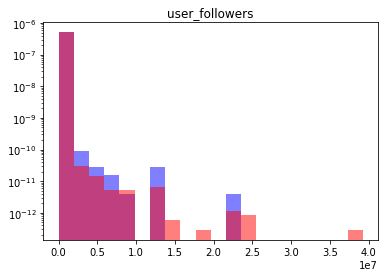

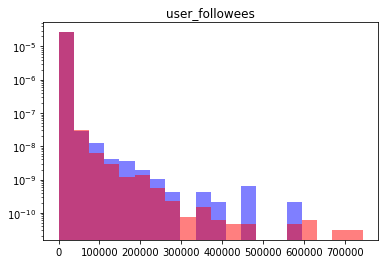

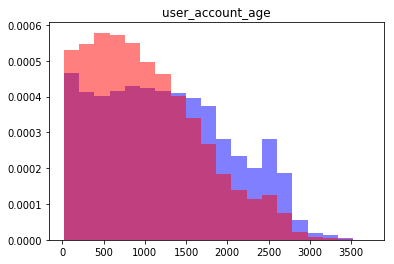

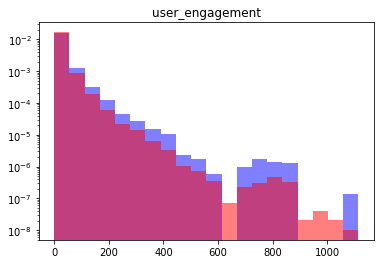

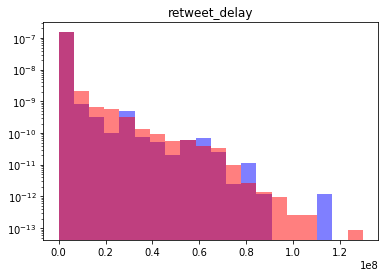

In [24]:
for (c, lg) in zip(to_display, [True, True, False, True, True]):
    plt.hist(tweets[tweets.veracity][c], color='blue', alpha=0.5, density=True,
             bins=20, log=lg, range = [tweets[c].min(), tweets[c].max()])
    plt.hist(tweets[~tweets.veracity][c], color='red', alpha=0.5, density=True,
             bins=20, log=lg, range = [tweets[c].min(), tweets[c].max()])
    plt.title(c)
    plt.show()

In [19]:
cascades[['cascade_size', 'cascade_followers']].describe().style.format('{:.4f}')

,cascade_size,cascade_followers
count,2155.0000,2155.0000
mean,876.4538,2150098.1155
std,1405.0587,3275835.1317
min,100.0000,4269.0000
25%,168.0000,463866.5000
50%,324.0000,1025287.0000
75%,829.0000,2546196.0000
max,9990.0000,43428570.0000


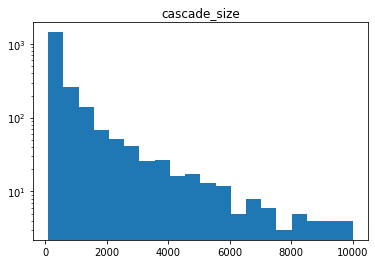

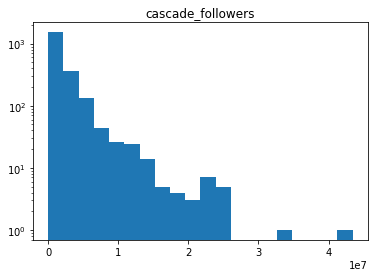

In [22]:
for c in ['cascade_size', 'cascade_followers']:
    plt.hist(cascades[c], bins=20, log=True, range = [cascades[c].min(), cascades[c].max()])
    plt.title(c)
    #plt.savefig('plots/'+c+'.png')
    plt.show()

In [33]:
df_emo = pd.merge(df_emo, cascades[['cascade_id', 'veracity']], how = 'inner', on = 'cascade_id')

In [39]:
emos = ['sadness', 'anticipation', 'disgust', 'surprise', 'anger',
       'joy', 'fear', 'trust']

In [66]:
pd.set_option('display.precision', 3)

df_emo.groupby('veracity').agg({k:'mean' for k in emos}).reset_index().melt('veracity').pivot('variable', 'veracity')

value       
veracity      False  True 
variable                  
anger         0.133  0.131
anticipation  0.142  0.151
disgust       0.225  0.219
fear          0.098  0.100
joy           0.083  0.091
sadness       0.065  0.073
surprise      0.147  0.132
trust         0.107  0.102

In [68]:
df_emo.groupby('veracity').agg({k:np.std for k in emos}).reset_index().melt('veracity').pivot('variable', 'veracity')

value       
veracity      False  True 
variable                  
anger         0.051  0.044
anticipation  0.056  0.053
disgust       0.084  0.070
fear          0.056  0.047
joy           0.050  0.072
sadness       0.034  0.039
surprise      0.070  0.045
trust         0.047  0.044